# ANN Multi Output Multi Category Classification


In [58]:
# Imports
import numpy as np

import torch
import torch.nn as nn

# Pytorch Gpu Configuration
import torch_directml
device = torch_directml.device()
torch.set_default_device(device)



import matplotlib.pyplot as plt

# Matplotlib svg plots for better pictures
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

import seaborn as sns

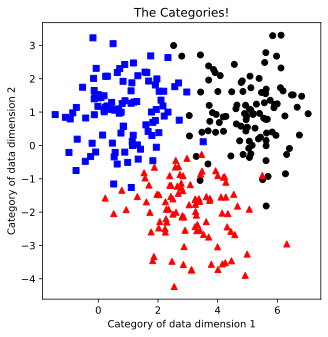

In [59]:
# Create the data
nPerCluster = 100
blur = 1  # Std Deviation of 1

A = [  1,  1 ]
B = [  5,  1 ]
C = [  3, -2 ]


# Generate the data
a = [
    A[0] + np.random.randn(nPerCluster) * blur,
    A[1] + np.random.randn(nPerCluster) * blur,
]
b = [
    B[0] + np.random.randn(nPerCluster) * blur,
    B[1] + np.random.randn(nPerCluster) * blur,
]
c = [
    C[0] + np.random.randn(nPerCluster) * blur,
    C[1] + np.random.randn(nPerCluster) * blur,
]

# True labels
labels_np = np.vstack(
    (
        np.zeros((nPerCluster, 1)),
        np.ones((nPerCluster, 1)),
        np.full((nPerCluster, 1), 2),
    )
)
# Stack it into a matrix
data_np = np.hstack((a, b, c)).T

# Convert np matrix into a tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# Plot the data
fig = plt.figure(figsize=(5, 5))
plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
)
plt.title("The Categories!")
plt.xlabel("Category of data dimension 1")
plt.ylabel("Category of data dimension 2")
plt.show()

In [65]:
# Create ANN model
def nn_model(lr):
    # Model Architecture
    ANN_model = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
        nn.Softmax(dim=1),
    )

    # Loss Function
    loss_fun = nn.CrossEntropyLoss()  # This has softmax built in
    # Optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(), lr=lr)
    # test the model
    yHat = ANN_model(data)
    return ANN_model, loss_fun, optimizer

In [66]:
# Train the model
def train_the_model(model, loss_fun, optimizer, n_epoches, labels, data):

    # Initialization of losses and onGoingAccuracy
    losses = torch.zeros(n_epoches)
    on_going_acc = []

    # The Loop
    for epoch in range(n_epoches):

        # Forward Pass
        yHat = model(data)

        # Compute Loss
        loss = loss_fun(yHat, labels)
        losses[epoch] = loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute the accuracy
        matches = torch.argmax(yHat, axis=1) == labels  # Returns boolean
        matches_numeric = matches.float()
        accuracy_epoch = 100 * torch.mean(matches_numeric)
        on_going_acc.append(accuracy_epoch.cpu().detach())

    # Predictions
    predictions = model(data)

    pred_labels = torch.argmax(predictions, axis=1)
    total_acc = 100 * torch.mean((pred_labels == labels).float())
    return losses, total_acc, on_going_acc, yHat

In [67]:
learning_rate = 0.1
n_epoches = 1500
ANN_model, loss_fun, optimizer = nn_model(lr=learning_rate)
losses, total_acc, on_going_acc, yHat = train_the_model(
    ANN_model, loss_fun, optimizer, n_epoches, labels, data
)
print(f"Final Accuracy: {total_acc}")

Final Accuracy: 97.66667175292969


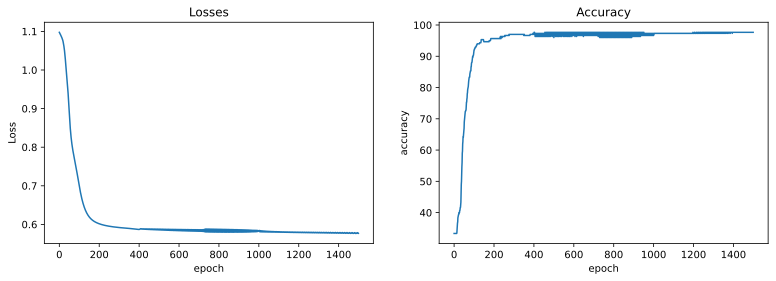

In [68]:
# Result Visualization

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.cpu().detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(on_going_acc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()

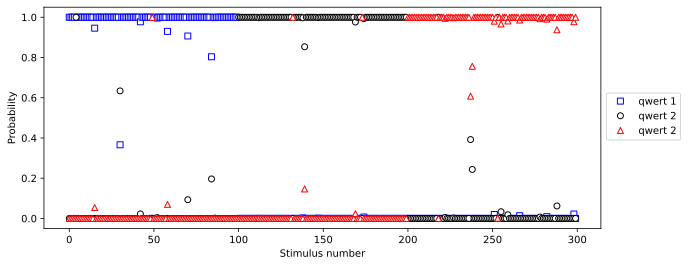

In [69]:
# plot the raw model outputs

fig = plt.figure(figsize=(10,4))

colorshape = [  'bs','ko','r^' ]
for i in range(3):
  plt.plot(yHat[:,i].cpu().detach(),colorshape[i],markerfacecolor='w')

plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['qwert 1','qwert 2','qwert 2'],loc=(1.01,.4))
plt.show()